<a href="https://colab.research.google.com/github/JALVARADORUIZ/Magister_BigData_UB/blob/main/TFM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **PREPARACIÓN DEL ENTORNO**


In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

In [ ]:
from keras.applications.vgg16 import VGG16 
from keras.models import Model

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

#### **PREPROCESADO DE IMÁGENES**


In [ ]:
path = r"/content/drive/MyDrive/TFM_Máster BDDS/datawine/vintage-images"
os.chdir(path)


In [ ]:
wines = []

with os.scandir(path) as files:
    for file in files:
        wines.append(file.name)

In [ ]:

img = load_img(wines[0], target_size=(224,224))

img = np.array(img)

print(img.shape)

(224, 224, 3)


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
reshaped_img = img.reshape(1,224,224,3)
print(reshaped_img.shape)


(1, 224, 224, 3)


In [ ]:
x = preprocess_input(reshaped_img)

In [ ]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [ ]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [ ]:
data = {}
p = r"/content/drive/MyDrive/TFM_Máster BDDS/datawine/wine_features.pkl"

# loop through each image in the dataset
for wine in wines:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(wine,model)
        data[wine] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)
          
 
# get a list of the filenames
filenames = np.array(list(data.keys()))




(7618, 4096)

In [ ]:
# get a list of just the features
feat = np.array(list(data.values()))
feat.shape

(7618, 1, 4096)

In [ ]:
# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)
feat.shape

(7618, 4096)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/TFM_Máster BDDS/datawine/df_clean.csv')
df.head(5)

winery                                            product  \
0    cathedral ridge  cathedral ridge bangsund vineyard pinot noir 2006   
1           penfolds                           penfolds rwt shiraz 2005   
2  marques de riscal       marques de riscal frank gehry selection 2001   
3            wyndham                    wyndham pinot noir bin 333 2007   
4        louis jadot    louis jadot chevalier montrachet grand cru 2006   

                           region country_code  rating       variety  \
0          columbia valley oregon           us     3.5    pinot noir   
1                  barossa valley           au     4.5  shiraz syrah   
2                           rioja           es     5.0   tempranillo   
3         south eastern australia           au     4.0    pinot noir   
4  chevalier montrachet grand cru           fr     5.0    chardonnay   

    price_usd                                              image  \
0  163.000000  vintage-images/MBo5T9ZQQQGbzsRmVORp-w_pl_480x6...   
1  169.950000  vintage-images/dDyTwzIfQC68MCUgjmYWpw_pl_480x6...   
2  357.196682  vintage-images/t44NPpbUT6uy0vRt4VD2RQ_pl_480x6...   
3   10.990000  vintage-images/v1RahJe2QQyp4oAFOv90bA_pl_480x6...   
4  309.990000  vintage-images/VlMihlZUQE6US7fr09w5ZA_pl_480x6...   

      continente country_code_clean         price_cat    quality  \
0  north america      united states   (1.003, 301.99]        NaN   
1        oceania          australia   (1.003, 301.99]        NaN   
2         europe              spain  (301.99, 601.48]        NaN   
3        oceania          australia   (1.003, 301.99]        NaN   
4         europe             france  (301.99, 601.48]  grand cru   

                             image_clean  
0  MBo5T9ZQQQGbzsRmVORp-w_pl_480x640.png  
1  dDyTwzIfQC68MCUgjmYWpw_pl_480x640.png  
2  t44NPpbUT6uy0vRt4VD2RQ_pl_480x640.png  
3  v1RahJe2QQyp4oAFOv90bA_pl_480x640.png  
4  VlMihlZUQE6US7fr09w5ZA_pl_480x640.png

In [ ]:
#df_images = pd.DataFrame(list(data.items()),columns = ['image_clean','features'])
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)
df_images = pd.DataFrame(x)
df_filenames = pd.DataFrame(filenames,columns = ['image_clean'])
df_imagesf = pd.concat([df_filenames, df_images], axis=1)
dff = df.merge(df_imagesf, how='left', on='image_clean')

##**KKN Clusterización**


###**VARIEDAD**

In [ ]:
label = df['variety'].tolist()
unique_labels = list(set(label))

In [ ]:
len(unique_labels)

257

In [ ]:
dff1 = dff.drop([513, 610, 2461, 2628, 2784, 2967, 3857, 4136, 5179, 5819, 5928, 6194, 6707, 6917, 7030, 7042, 7472],axis=0)

In [ ]:
kmeans = KMeans(n_clusters=len(unique_labels), random_state=22)
kmeans.fit(dff1.iloc[:,14:])

KMeans(n_clusters=257, random_state=22)

In [ ]:
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [ ]:
def view_cluster(cluster):
    plt.figure(figsize = (50,50));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')
        

Clipping cluster size from 65 to 30


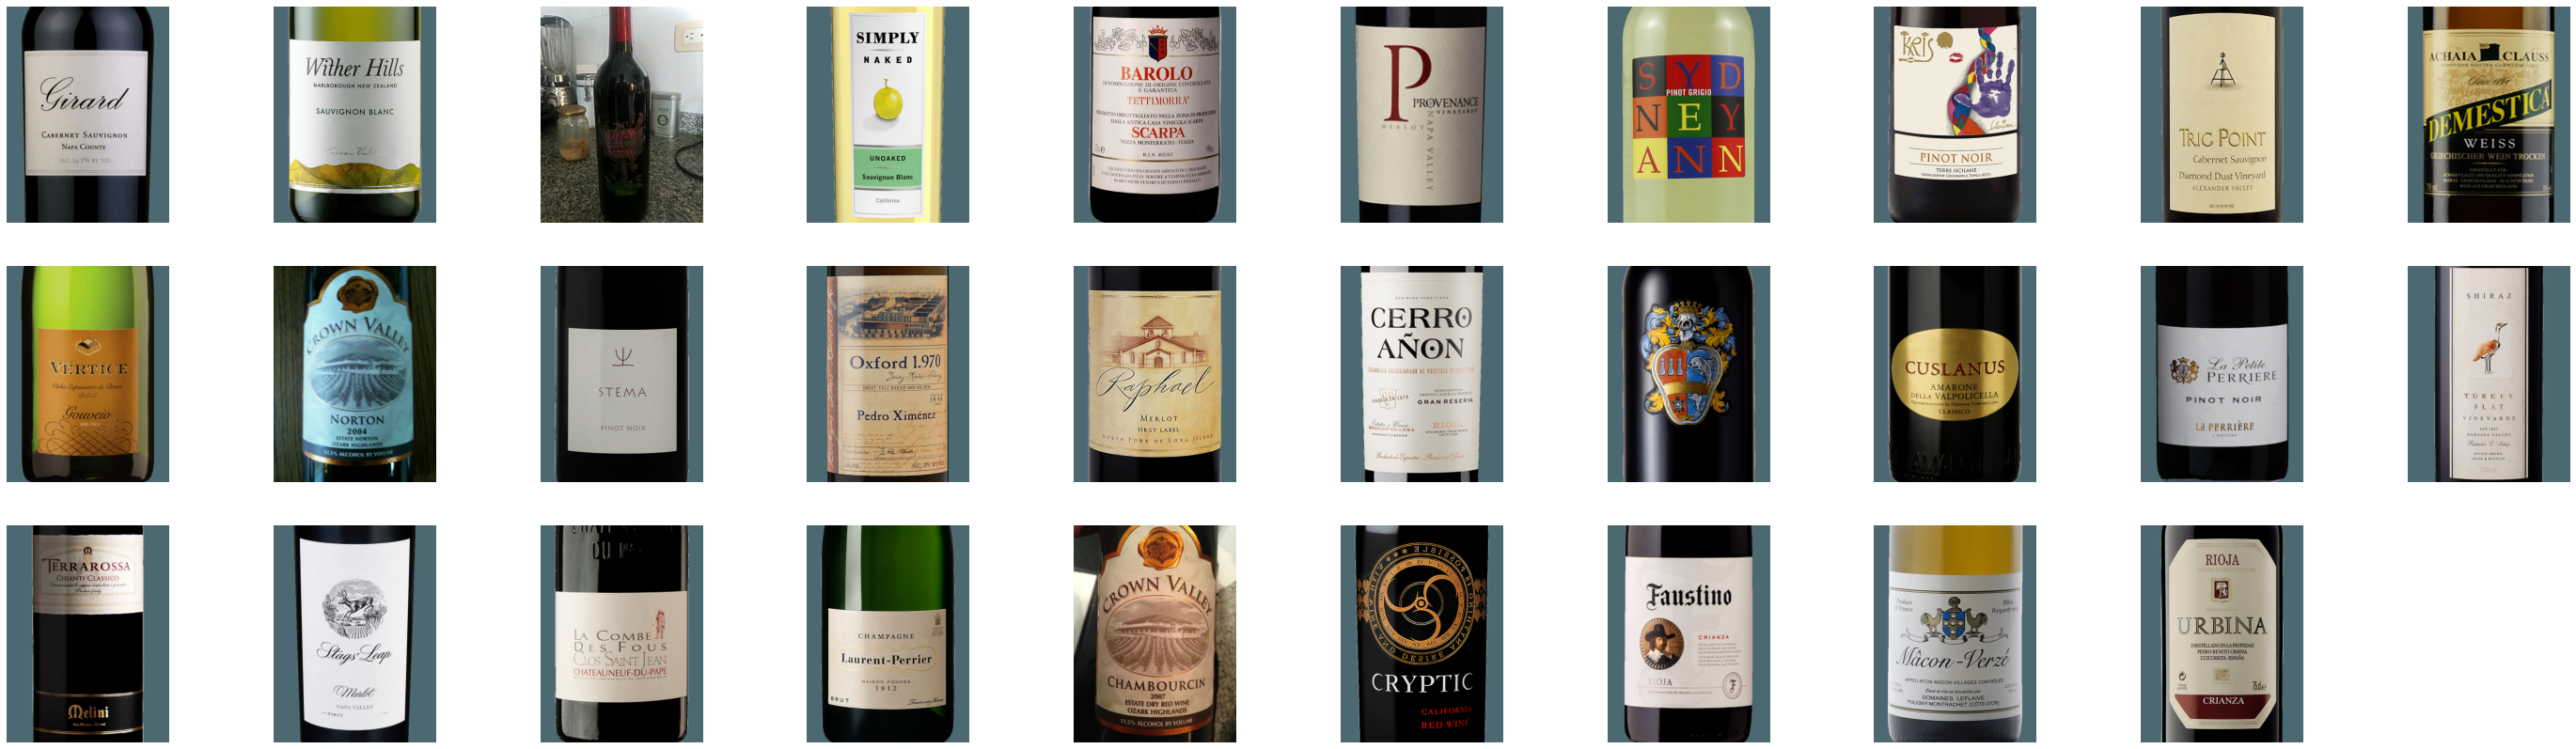

In [ ]:
view_cluster(0)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


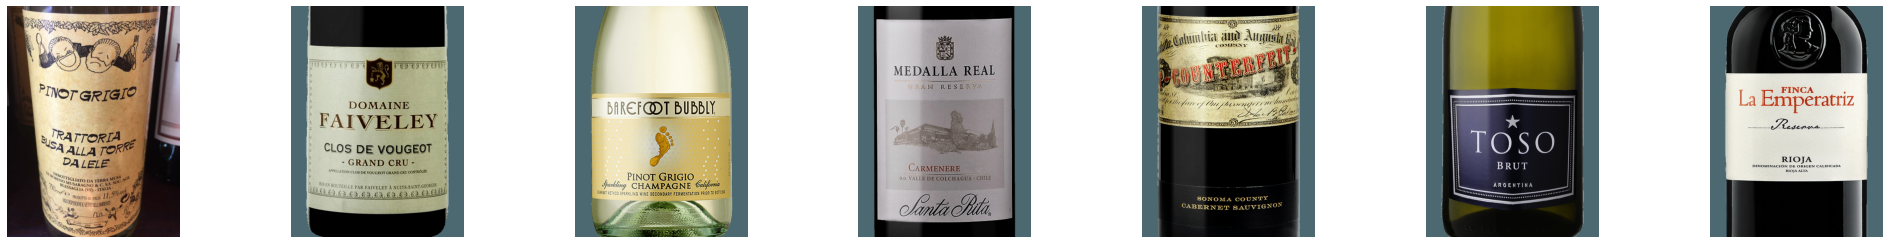

In [ ]:
view_cluster(1)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


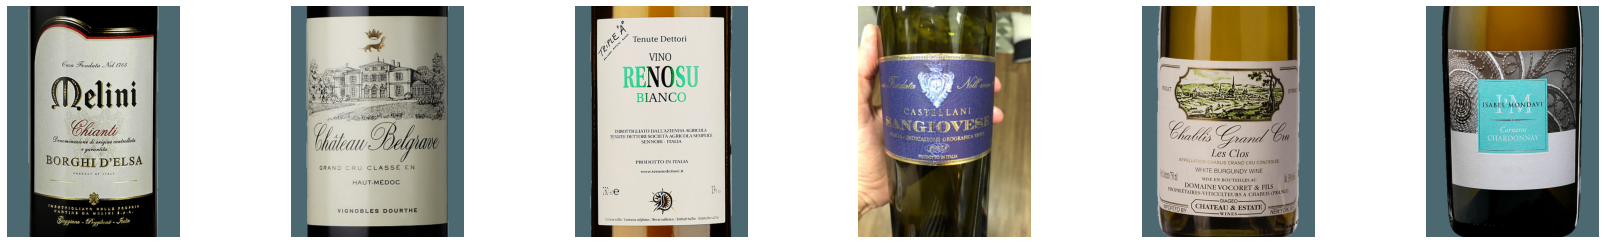

In [ ]:
view_cluster(2)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


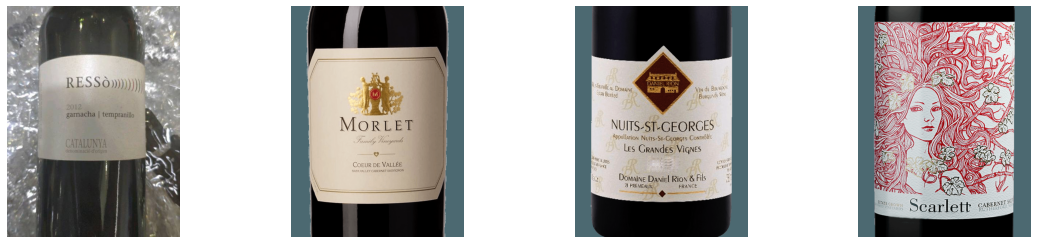

In [ ]:
view_cluster(3)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


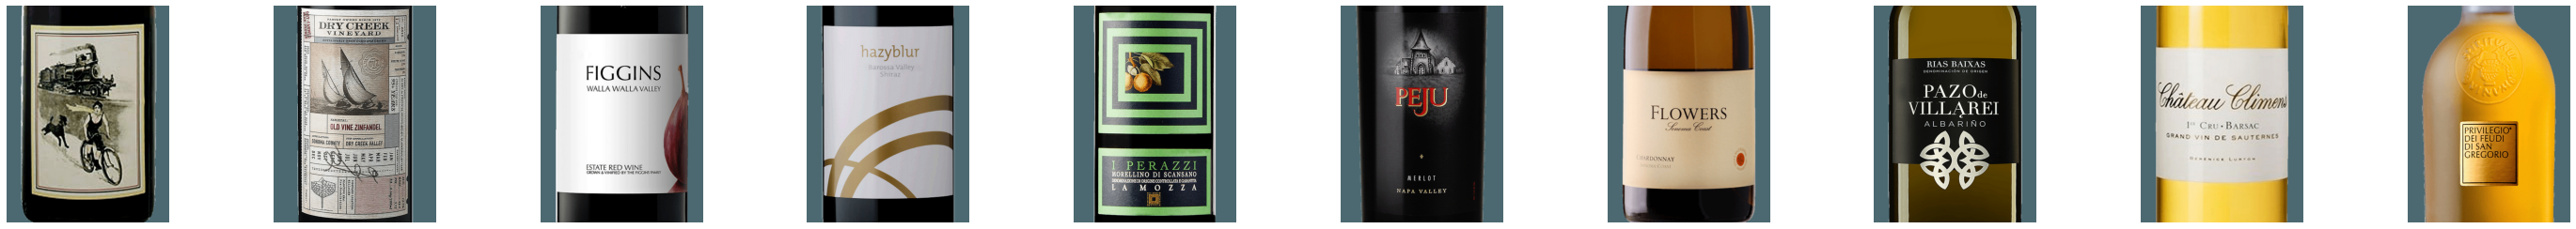

In [ ]:
view_cluster(4)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


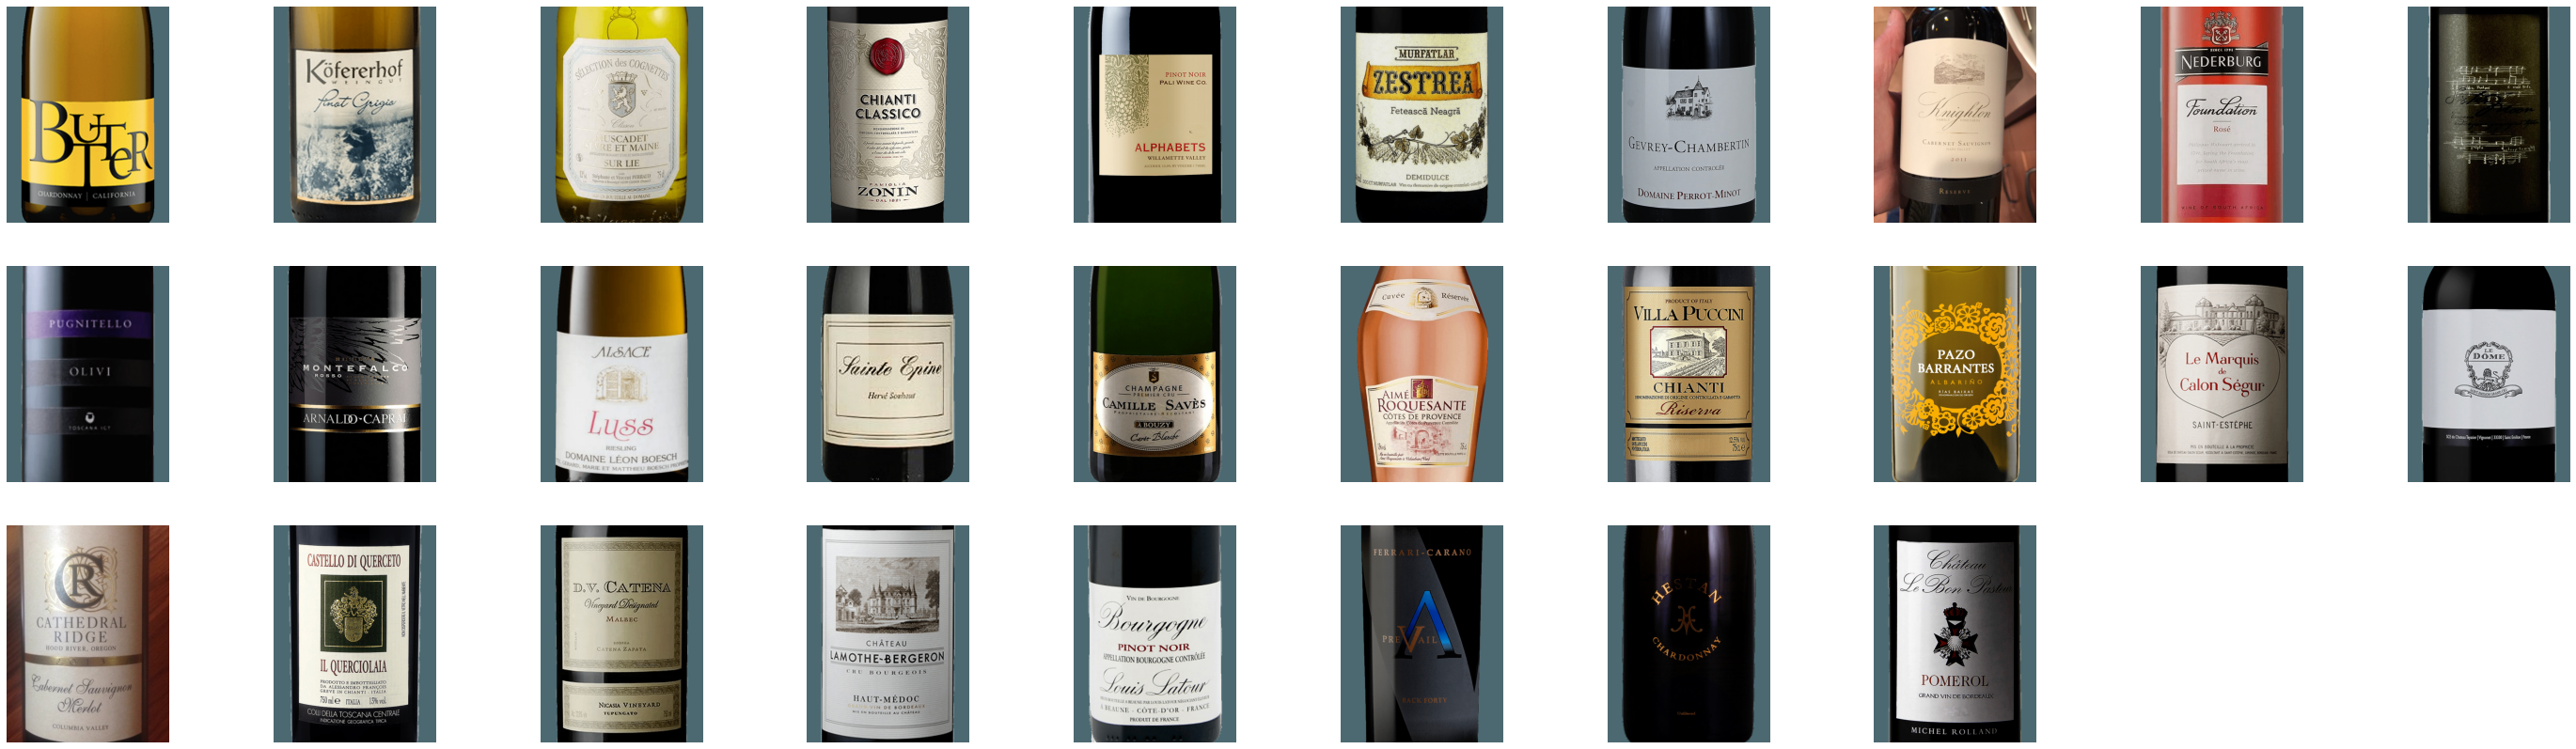

In [ ]:
view_cluster(5)

#**CLASIFICADOR KNN**#

###**VARIEDAD**###



In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
variedad = le.fit_transform(dff1['variety'])
print(variedad)

[172 207 212 ... 172 125  43]


In [ ]:
X = dff1.iloc[:,14:].values
y = variedad

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
classifier = KNeighborsClassifier(n_neighbors= 4)

In [ ]:
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

result = confusion_matrix(y_test, y_pred)

print('Confusion Matrix')

print(result)

result2 = accuracy_score(y_test, y_pred)
print('Accuracy:', result2)

Confusion Matrix
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 0]]
Accuracy: 0.4073886639676113


###**TIER DE PRECIO**###


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
price_cats = le.fit_transform(dff1['price_cat'])
print(price_cats)

X = dff1.iloc[:,14:].values
y = price_cats


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors= 4)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

result = confusion_matrix(y_test, y_pred)

print('Confusion Matrix')

print(result)

result2 = accuracy_score(y_test, y_pred)
print('Accuracy:', result2)

[0 0 2 ... 0 0 0]
Confusion Matrix
[[1781    1   31    5    1]
 [   2    0    0    1    0]
 [  70    0   38    8    2]
 [  10    0    6    5    0]
 [   9    0    2    3    1]]
Accuracy: 0.923582995951417
